In [1]:
########################################################################
########################################################################
##                                                                    ##
##                      ORIGINAL _ DO NOT PUBLISH                     ##
##                                                                    ##
########################################################################
########################################################################

import torch as tr
import torch
from torch.nn.functional import pad
import torch.nn as nn
import numpy as np
import loader as ld
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


batch_size = 32
output_size = 2
hidden_size = 64        # to experiment with

run_recurrent = True    # else run Token-wise MLP
use_RNN = True          # otherwise GRU
atten_size = 0          # atten > 0 means using restricted self atten

reload_model = False
num_epochs = 10
learning_rate = 0.0001
test_interval = 300

# Loading sataset, use toy = True for obtaining a smaller dataset

train_dataset, test_dataset, num_words, input_size = ld.get_data_set(batch_size)

# Special matrix multipication layer (like torch.Linear but can operate on arbitrary sized
# tensors and considers its last two indices as the matrix.)

class MatMul(nn.Module):
    def __init__(self, in_channels, out_channels, use_bias = True):
        super(MatMul, self).__init__()
        self.matrix = torch.nn.Parameter(torch.nn.init.xavier_normal_(torch.empty(in_channels,out_channels)), requires_grad=True)
        if use_bias:
            self.bias = torch.nn.Parameter(torch.zeros(1,1,out_channels), requires_grad=True)

        self.use_bias = use_bias

    def forward(self, x):        
        x = torch.matmul(x,self.matrix) 
        if self.use_bias:
            x = x+ self.bias 
        return x
        
# Implements RNN Unit

class ExRNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(ExRNN, self).__init__()
        self.hidden_size = hidden_size
        self.sigmoid = nn.Sigmoid()
        # self.in2hidden = nn.Linear(input_size + hidden_size, hidden_size)
        self.in2hidden = MatMul(input_size, hidden_size)
        self.prev_hidden2hidden = MatMul(hidden_size, hidden_size)
        self.hidden2out = MatMul(hidden_size, output_size)

    def name(self):
        return "RNN"

    def forward(self, x, hidden_state):
        hidden_state = self.sigmoid(self.prev_hidden2hidden(hidden_state) + self.in2hidden(x))
        output = self.sigmoid(self.hidden2out(hidden_state))
        return output.squeeze(), hidden_state

    def init_hidden(self, bs):
        return torch.zeros(bs, self.hidden_size).cuda()

# Implements GRU Unit

class ExGRU(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(ExGRU, self).__init__()
        self.hidden_size = hidden_size
        self.update_gate = MatMul(input_size, hidden_size)
        self.reset_gate = MatMul(input_size, hidden_size)
        self.out_gate = MatMul(hidden_size, hidden_size)
        self.hidden2out = MatMul(hidden_size, output_size)

    def name(self):
        return "GRU"

    def forward(self, x, hidden_state):
        update = torch.sigmoid(self.update_gate(x))
        reset = torch.sigmoid(self.reset_gate(x))
        combined_reset = reset * hidden_state
        hidden_state = update * hidden_state + (1 - update) * torch.tanh(self.out_gate(combined_reset))
        output = self.hidden2out(hidden_state)
        return output.squeeze(), hidden_state

    def init_hidden(self, bs):
        return self.hidden_size


class ExMLP(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(ExMLP, self).__init__()

        self.ReLU = torch.nn.ReLU()

        # Token-wise MLP network weights
        self.layer1 = MatMul(input_size,hidden_size)
        # additional layer(s)
        

    def name(self):
        return "MLP"

    def forward(self, x):

        # Token-wise MLP network implementation
        
        x = self.layer1(x)
        x = self.ReLU(x)
        # rest

        return x


# prints portion of the review (20-30 first words), with the sub-scores each work obtained
# prints also the final scores, the softmaxed prediction values and the true label values

def print_review(rev_text, sbs1, sbs2, lbl1, lbl2):
    pass
    # implement

# select model to use

/home/orian/PycharmProjects/deepLearning/.venv/lib/python3.10/site-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/orian/PycharmProjects/deepLearning/.venv/lib/python3.10/site-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/home/orian/PycharmProjects/deepLearning/.venv/lib/python3.10/site-packages/torchtext

Using model: GRU
Accuracy: 0.4375
Epoch [1/10], Step [300/938], Train Loss: 0.6938, Test Loss: 0.7549
Accuracy: 0.375
Epoch [1/10], Step [600/938], Train Loss: 0.6894, Test Loss: 0.7077
Accuracy: 0.46875
Epoch [1/10], Step [900/938], Train Loss: 0.6935, Test Loss: 0.6958
Accuracy: 0.625
Epoch [2/10], Step [300/938], Train Loss: 0.6213, Test Loss: 0.6332
Accuracy: 0.53125
Epoch [2/10], Step [600/938], Train Loss: 0.4989, Test Loss: 0.6781
Accuracy: 0.75
Epoch [2/10], Step [900/938], Train Loss: 0.6099, Test Loss: 0.5921
Accuracy: 0.84375
Epoch [3/10], Step [300/938], Train Loss: 0.6150, Test Loss: 0.5015
Accuracy: 0.625
Epoch [3/10], Step [600/938], Train Loss: 0.6124, Test Loss: 0.6312
Accuracy: 0.625
Epoch [3/10], Step [900/938], Train Loss: 0.5068, Test Loss: 0.7065
Accuracy: 0.625
Epoch [4/10], Step [300/938], Train Loss: 0.4255, Test Loss: 0.5270
Accuracy: 0.625
Epoch [4/10], Step [600/938], Train Loss: 0.5657, Test Loss: 0.6155
Accuracy: 0.6875
Epoch [4/10], Step [900/938], Train 

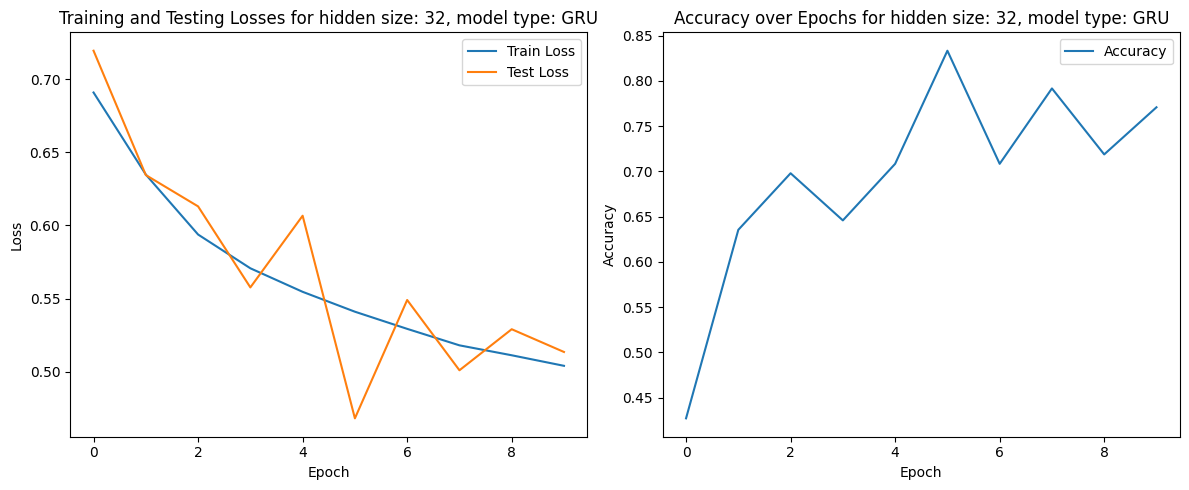

Using model: GRU
Accuracy: 0.5625
Epoch [1/10], Step [300/938], Train Loss: 0.6929, Test Loss: 0.7543
Accuracy: 0.3125
Epoch [1/10], Step [600/938], Train Loss: 0.6934, Test Loss: 0.7065
Accuracy: 0.53125
Epoch [1/10], Step [900/938], Train Loss: 0.6926, Test Loss: 0.6942
Accuracy: 0.5625
Epoch [2/10], Step [300/938], Train Loss: 0.6502, Test Loss: 0.6689
Accuracy: 0.5
Epoch [2/10], Step [600/938], Train Loss: 0.6204, Test Loss: 0.6716
Accuracy: 0.6875
Epoch [2/10], Step [900/938], Train Loss: 0.6354, Test Loss: 0.5791
Accuracy: 0.71875
Epoch [3/10], Step [300/938], Train Loss: 0.6074, Test Loss: 0.6552
Accuracy: 0.71875
Epoch [3/10], Step [600/938], Train Loss: 0.4806, Test Loss: 0.6005
Accuracy: 0.625
Epoch [3/10], Step [900/938], Train Loss: 0.5973, Test Loss: 0.6447
Accuracy: 0.875
Epoch [4/10], Step [300/938], Train Loss: 0.5731, Test Loss: 0.4984
Accuracy: 0.75
Epoch [4/10], Step [600/938], Train Loss: 0.6291, Test Loss: 0.4741
Accuracy: 0.78125
Epoch [4/10], Step [900/938], Trai

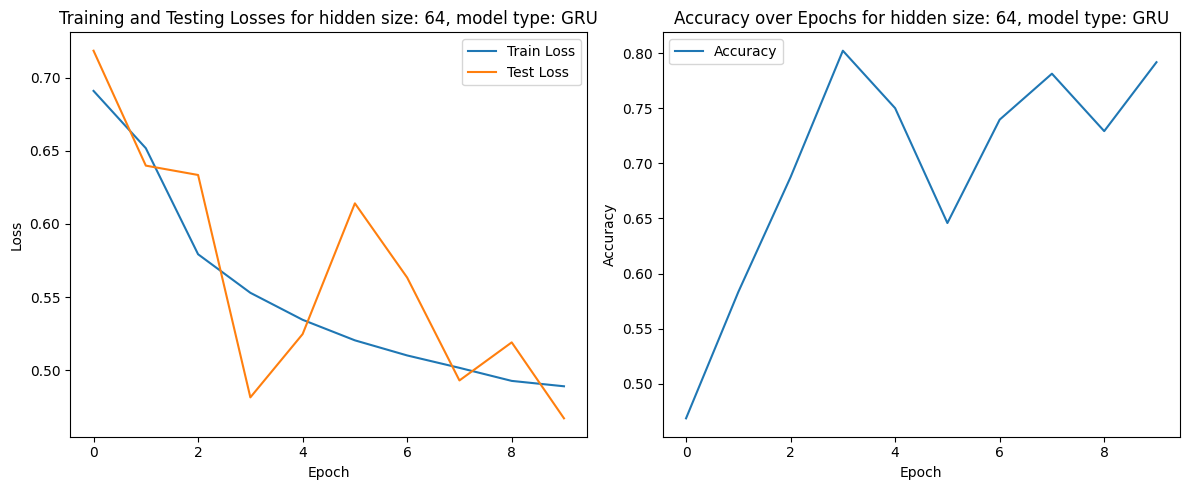

Using model: GRU
Accuracy: 0.625
Epoch [1/10], Step [300/938], Train Loss: 0.6947, Test Loss: 0.7527
Accuracy: 0.5
Epoch [1/10], Step [600/938], Train Loss: 0.6942, Test Loss: 0.7049
Accuracy: 0.65625
Epoch [1/10], Step [900/938], Train Loss: 0.6919, Test Loss: 0.6929
Accuracy: 0.71875
Epoch [2/10], Step [300/938], Train Loss: 0.6674, Test Loss: 0.6384
Accuracy: 0.65625
Epoch [2/10], Step [600/938], Train Loss: 0.6045, Test Loss: 0.6278
Accuracy: 0.8125
Epoch [2/10], Step [900/938], Train Loss: 0.5849, Test Loss: 0.4651
Accuracy: 0.65625
Epoch [3/10], Step [300/938], Train Loss: 0.4441, Test Loss: 0.5637
Accuracy: 0.65625
Epoch [3/10], Step [600/938], Train Loss: 0.4073, Test Loss: 0.6339
Accuracy: 0.6875
Epoch [3/10], Step [900/938], Train Loss: 0.6145, Test Loss: 0.5549
Accuracy: 0.71875
Epoch [4/10], Step [300/938], Train Loss: 0.4318, Test Loss: 0.5807
Accuracy: 0.90625
Epoch [4/10], Step [600/938], Train Loss: 0.5276, Test Loss: 0.3683
Accuracy: 0.6875
Epoch [4/10], Step [900/938]

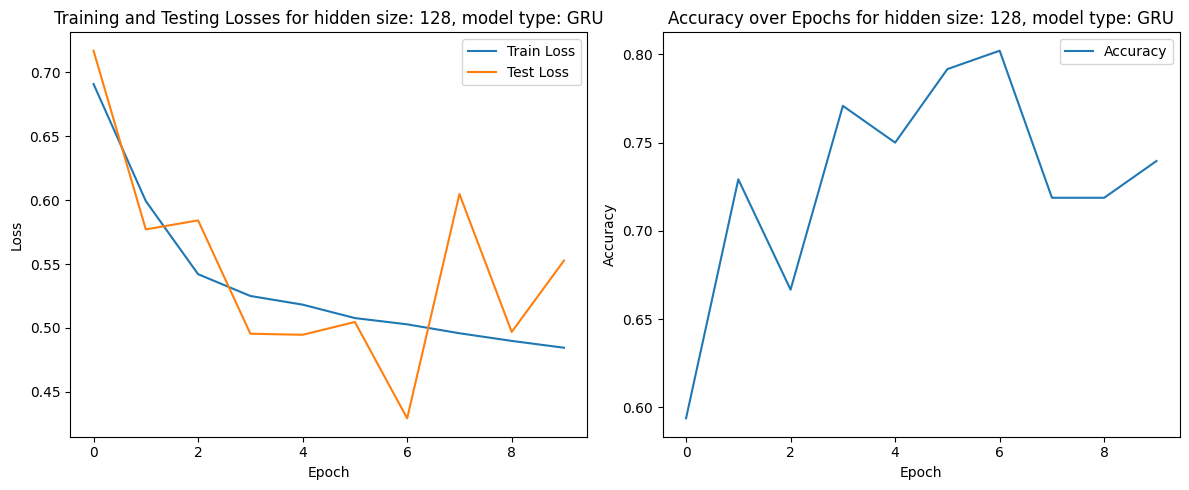

Using model: GRU
Accuracy: 0.40625
Epoch [1/10], Step [300/938], Train Loss: 0.6915, Test Loss: 0.7586
Accuracy: 0.46875
Epoch [1/10], Step [600/938], Train Loss: 0.6925, Test Loss: 0.7060
Accuracy: 0.5
Epoch [1/10], Step [900/938], Train Loss: 0.6876, Test Loss: 0.6931
Accuracy: 0.75
Epoch [2/10], Step [300/938], Train Loss: 0.5988, Test Loss: 0.5996
Accuracy: 0.75
Epoch [2/10], Step [600/938], Train Loss: 0.6020, Test Loss: 0.5449
Accuracy: 0.78125
Epoch [2/10], Step [900/938], Train Loss: 0.5676, Test Loss: 0.5364
Accuracy: 0.78125
Epoch [3/10], Step [300/938], Train Loss: 0.6914, Test Loss: 0.4863
Accuracy: 0.90625
Epoch [3/10], Step [600/938], Train Loss: 0.4712, Test Loss: 0.3957
Accuracy: 0.8125
Epoch [3/10], Step [900/938], Train Loss: 0.5471, Test Loss: 0.4714
Accuracy: 0.71875
Epoch [4/10], Step [300/938], Train Loss: 0.4605, Test Loss: 0.4900
Accuracy: 0.75
Epoch [4/10], Step [600/938], Train Loss: 0.4447, Test Loss: 0.5282
Accuracy: 0.71875
Epoch [4/10], Step [900/938], Tra

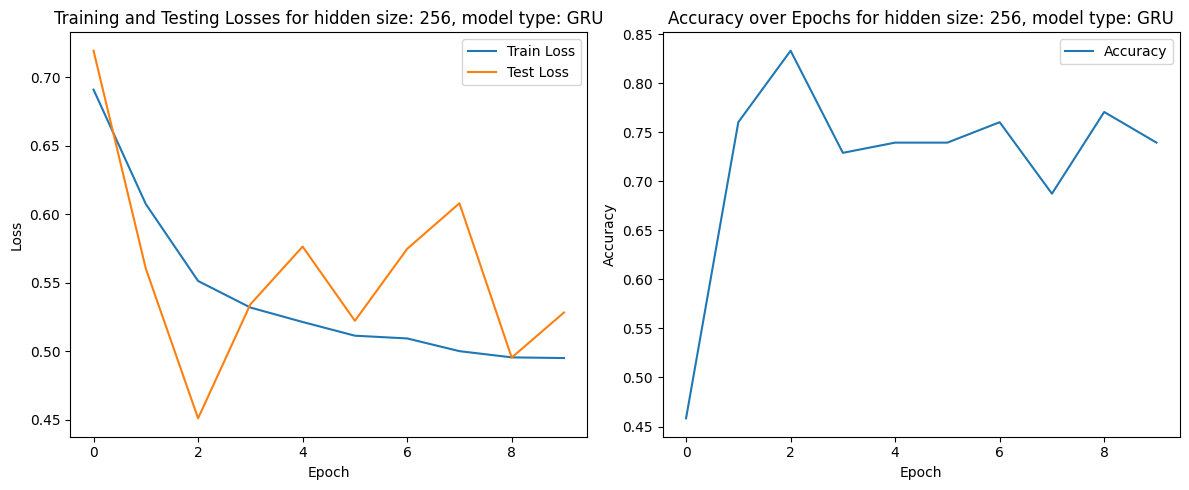

Using model: RNN
Accuracy: 0.625
Epoch [1/10], Step [300/938], Train Loss: 0.6974, Test Loss: 0.7495
Accuracy: 0.5625
Epoch [1/10], Step [600/938], Train Loss: 0.6912, Test Loss: 0.6973
Accuracy: 0.5625
Epoch [1/10], Step [900/938], Train Loss: 0.6905, Test Loss: 0.6924
Accuracy: 0.5625
Epoch [2/10], Step [300/938], Train Loss: 0.6965, Test Loss: 0.6895
Accuracy: 0.46875
Epoch [2/10], Step [600/938], Train Loss: 0.6959, Test Loss: 0.7004
Accuracy: 0.4375
Epoch [2/10], Step [900/938], Train Loss: 0.6830, Test Loss: 0.6970
Accuracy: 0.375
Epoch [3/10], Step [300/938], Train Loss: 0.6779, Test Loss: 0.7061
Accuracy: 0.5
Epoch [3/10], Step [600/938], Train Loss: 0.6965, Test Loss: 0.6939
Accuracy: 0.5625
Epoch [3/10], Step [900/938], Train Loss: 0.7028, Test Loss: 0.6863
Accuracy: 0.4375
Epoch [4/10], Step [300/938], Train Loss: 0.6692, Test Loss: 0.6890
Accuracy: 0.59375
Epoch [4/10], Step [600/938], Train Loss: 0.7030, Test Loss: 0.6880
Accuracy: 0.5625
Epoch [4/10], Step [900/938], Trai

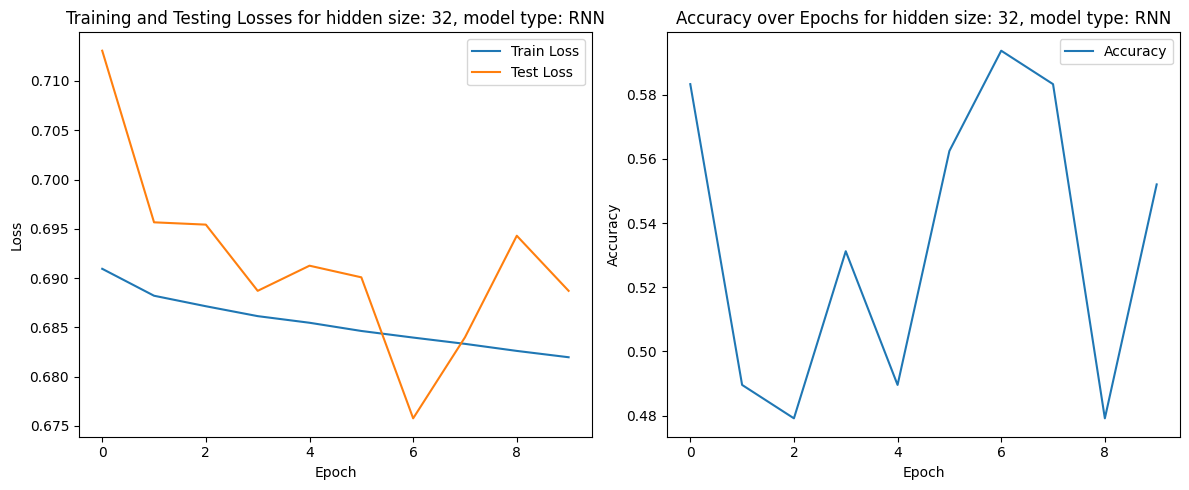

Using model: RNN
Accuracy: 0.375
Epoch [1/10], Step [300/938], Train Loss: 0.6939, Test Loss: 0.7563
Accuracy: 0.4375
Epoch [1/10], Step [600/938], Train Loss: 0.6924, Test Loss: 0.7097
Accuracy: 0.34375
Epoch [1/10], Step [900/938], Train Loss: 0.6880, Test Loss: 0.7040
Accuracy: 0.40625
Epoch [2/10], Step [300/938], Train Loss: 0.6959, Test Loss: 0.6990
Accuracy: 0.71875
Epoch [2/10], Step [600/938], Train Loss: 0.6858, Test Loss: 0.6853
Accuracy: 0.4375
Epoch [2/10], Step [900/938], Train Loss: 0.7051, Test Loss: 0.6936
Accuracy: 0.46875
Epoch [3/10], Step [300/938], Train Loss: 0.6784, Test Loss: 0.6979
Accuracy: 0.59375
Epoch [3/10], Step [600/938], Train Loss: 0.6856, Test Loss: 0.6915
Accuracy: 0.5
Epoch [3/10], Step [900/938], Train Loss: 0.6972, Test Loss: 0.6898
Accuracy: 0.59375
Epoch [4/10], Step [300/938], Train Loss: 0.6793, Test Loss: 0.6843
Accuracy: 0.4375
Epoch [4/10], Step [600/938], Train Loss: 0.6964, Test Loss: 0.6922
Accuracy: 0.65625
Epoch [4/10], Step [900/938]

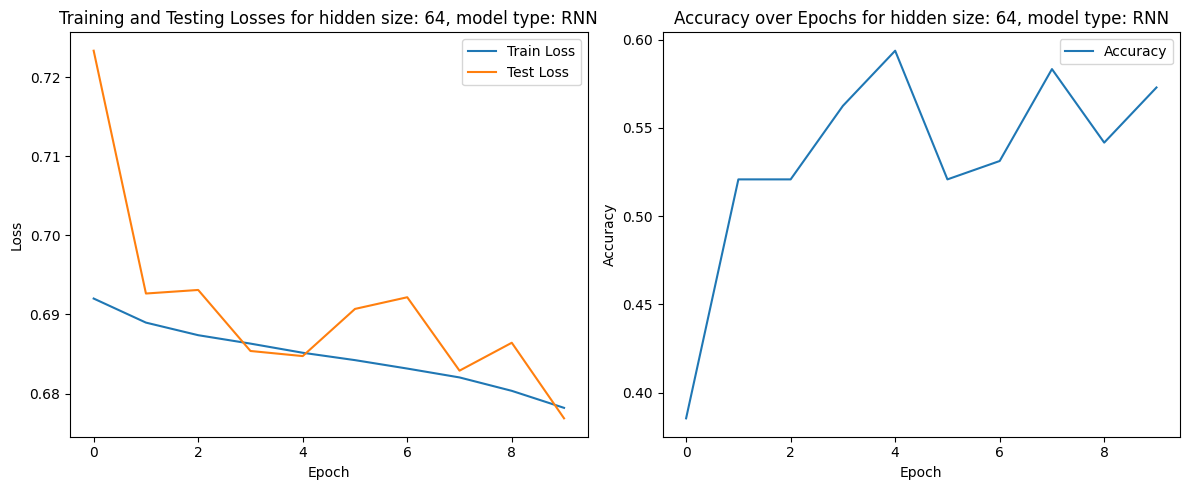

Using model: RNN
Accuracy: 0.40625
Epoch [1/10], Step [300/938], Train Loss: 0.6854, Test Loss: 0.7585
Accuracy: 0.5
Epoch [1/10], Step [600/938], Train Loss: 0.6845, Test Loss: 0.7051
Accuracy: 0.5625
Epoch [1/10], Step [900/938], Train Loss: 0.6930, Test Loss: 0.6928
Accuracy: 0.5625
Epoch [2/10], Step [300/938], Train Loss: 0.6863, Test Loss: 0.6897
Accuracy: 0.46875
Epoch [2/10], Step [600/938], Train Loss: 0.6699, Test Loss: 0.6937
Accuracy: 0.46875
Epoch [2/10], Step [900/938], Train Loss: 0.7074, Test Loss: 0.6892
Accuracy: 0.59375
Epoch [3/10], Step [300/938], Train Loss: 0.6884, Test Loss: 0.6723
Accuracy: 0.4375
Epoch [3/10], Step [600/938], Train Loss: 0.6827, Test Loss: 0.7044
Accuracy: 0.5
Epoch [3/10], Step [900/938], Train Loss: 0.6871, Test Loss: 0.6939
Accuracy: 0.5
Epoch [4/10], Step [300/938], Train Loss: 0.6829, Test Loss: 0.6858
Accuracy: 0.5625
Epoch [4/10], Step [600/938], Train Loss: 0.7008, Test Loss: 0.6885
Accuracy: 0.53125
Epoch [4/10], Step [900/938], Train

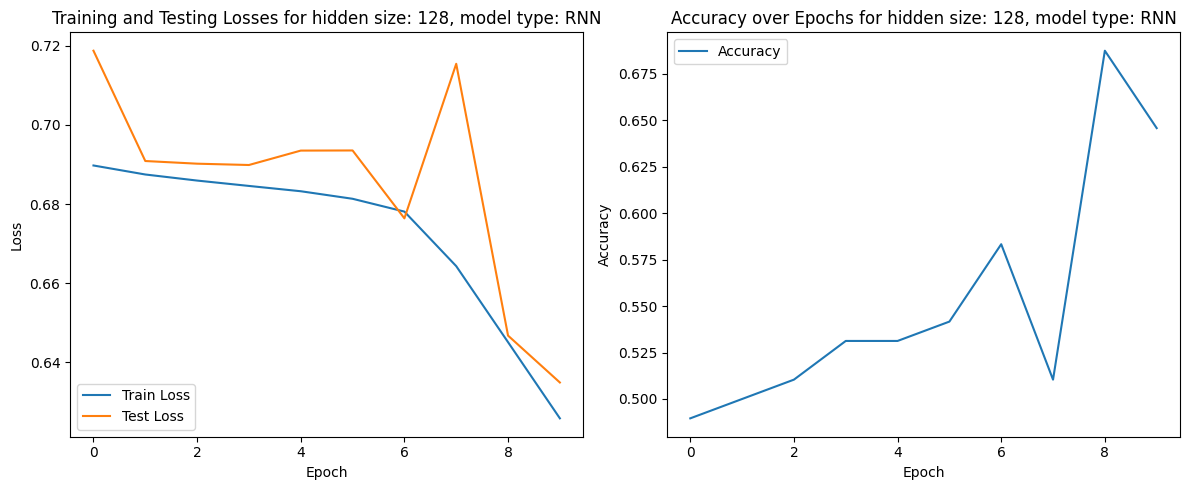

Using model: RNN
Accuracy: 0.40625
Epoch [1/10], Step [300/938], Train Loss: 0.6946, Test Loss: 0.7556
Accuracy: 0.53125
Epoch [1/10], Step [600/938], Train Loss: 0.6743, Test Loss: 0.7047
Accuracy: 0.40625
Epoch [1/10], Step [900/938], Train Loss: 0.6925, Test Loss: 0.7188
Accuracy: 0.65625
Epoch [2/10], Step [300/938], Train Loss: 0.6896, Test Loss: 0.6875
Accuracy: 0.59375
Epoch [2/10], Step [600/938], Train Loss: 0.6791, Test Loss: 0.6875
Accuracy: 0.46875
Epoch [2/10], Step [900/938], Train Loss: 0.7059, Test Loss: 0.6902
Accuracy: 0.5
Epoch [3/10], Step [300/938], Train Loss: 0.6716, Test Loss: 0.6936
Accuracy: 0.53125
Epoch [3/10], Step [600/938], Train Loss: 0.7022, Test Loss: 0.6748
Accuracy: 0.53125
Epoch [3/10], Step [900/938], Train Loss: 0.6780, Test Loss: 0.6944
Accuracy: 0.5625
Epoch [4/10], Step [300/938], Train Loss: 0.7105, Test Loss: 0.6740
Accuracy: 0.625
Epoch [4/10], Step [600/938], Train Loss: 0.6967, Test Loss: 0.6708
Accuracy: 0.5625
Epoch [4/10], Step [900/938

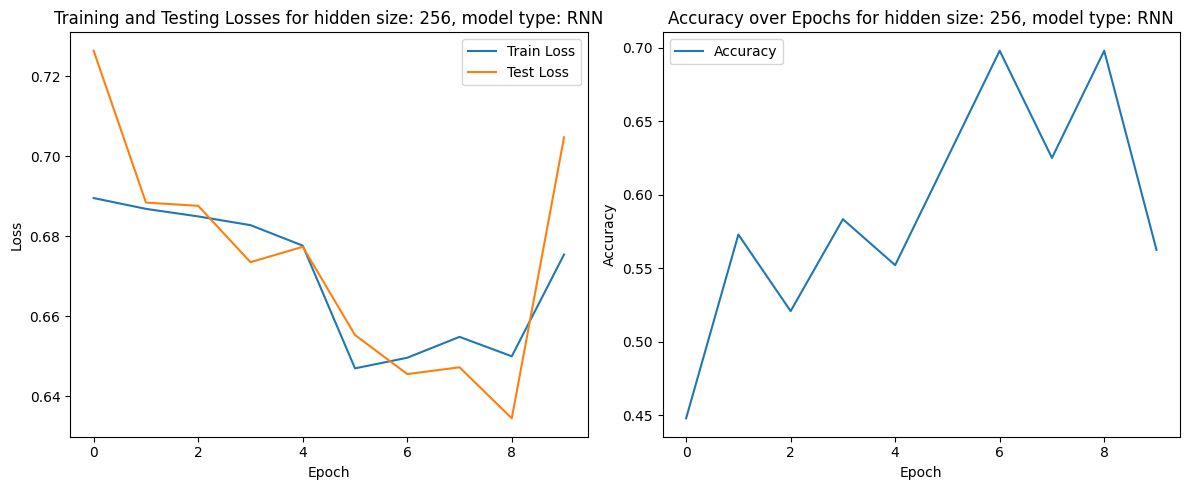

In [2]:
for use_RNN in [False, True]:
    for hidden_size in [32, 64, 128, 256]:
        if use_RNN:
            model = ExRNN(input_size, output_size, hidden_size)
        else:
            model = ExGRU(input_size, output_size, hidden_size)

        print("Using model: " + model.name())

        if reload_model:
            print("Reloading model")
            model.load_state_dict(torch.load(model.name() + ".pth"))

        model.cuda()

        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

        train_loss = 1.0
        test_loss = 1.0

        # training steps in which a test step is executed every test_interval

        model.train()

        train_losses = []
        test_losses = []
        accuracies = []

        for epoch in range(num_epochs):

            itr = 0 # iteration counter within each epoch
            epoch_train_loss = 0
            epoch_test_loss = 0
            epoch_accuracies = []

            for labels, reviews, reviews_text in train_dataset:   # getting training batches

                # test if the model can predict allways False
                # labels = torch.arange(0, 2, dtype=torch.float32).repeat(1024,1).cuda()

                itr = itr + 1

                if (itr + 1) % test_interval == 0:
                    test_iter = True
                    labels, reviews, reviews_text = next(iter(test_dataset)) # get a test batch 
                else:
                    test_iter = False

                # Recurrent nets (RNN/GRU)

                if run_recurrent:
                    hidden_state = model.init_hidden(int(labels.shape[0]))

                    for i in range(num_words):
                        output, hidden_state = model(reviews[:,i,:], hidden_state)  # HIDE

                else:  

                # Token-wise networks (MLP / MLP + Atten.) 
                
                    sub_score = []
                    if atten_size > 0:  
                        # MLP + atten
                        sub_score, atten_weights = model(reviews)
                    else:               
                        # MLP
                        sub_score = model(reviews)

                    output = torch.mean(sub_score, 1)
                    
                # cross-entropy loss

                loss = criterion(output, labels)

                # optimize in training iterations

                if not test_iter:
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                # averaged losses
                if test_iter:
                    test_loss = 0.8 * float(loss.detach()) + 0.2 * test_loss
                    epoch_test_loss += test_loss
                else:
                    train_loss = 0.9 * float(loss.detach()) + 0.1 * train_loss
                    epoch_train_loss += train_loss

                if test_iter:
                    accuracy = accuracy_score(torch.argmax(output, dim=1).cpu(), torch.argmax(labels, dim=1).cpu())
                    epoch_accuracies.append(accuracy)
                    print(f"Accuracy: {accuracy}")
                    print(
                        f"Epoch [{epoch + 1}/{num_epochs}], "
                        f"Step [{itr + 1}/{len(train_dataset)}], "
                        f"Train Loss: {train_loss:.4f}, "
                        f"Test Loss: {test_loss:.4f}"
                    )

                    if not run_recurrent:
                        nump_subs = sub_score.detach().numpy()
                        labels = labels.detach().numpy()
                        print_review(reviews_text[0], nump_subs[0,:,0], nump_subs[0,:,1], labels[0,0], labels[0,1])

                    # saving the model
                    torch.save(model, model.name() + ".pth")

            accuracies.append(sum(epoch_accuracies) / len(epoch_accuracies))    
            train_losses.append(epoch_train_loss / len(train_dataset))
            test_losses.append(epoch_test_loss / (len(train_dataset) // test_interval))


        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(range(num_epochs), train_losses, label='Train Loss')
        plt.plot(range(num_epochs), test_losses, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title(f'Training and Testing Losses for hidden size: {hidden_size}, model type: {"RNN" if use_RNN else "GRU"}')

        plt.subplot(1, 2, 2)
        plt.plot(range(len(accuracies)), accuracies, label='Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.title(f'Accuracy over Epochs for hidden size: {hidden_size}, model type: {"RNN" if use_RNN else "GRU"}')

        plt.tight_layout()
        plt.show()

In [3]:
from loader import preprocess_review, MAX_LENGTH

review_hard_for_rnn1 = "This movie was bad, starting with the amazing views and ending with a perfect sea view"
review_hard_for_rnn_rep = preprocess_review(review_hard_for_rnn1).cuda()

for model_type in ['GRU', 'RNN']:
    model = torch.load(f"{model_type}.pth")

    model.eval()

    with torch.no_grad():
        hidden_state = model.init_hidden(2)

        for i in range(MAX_LENGTH):
            output, hidden_state = model(review_hard_for_rnn_rep[:,i,:], hidden_state)  # HIDE

    if model_type == 'RNN':
        model_pred = "positive" if output[0][0] > output[0][1] else "negative"
    else:
        model_pred = "positive" if output[0] > output[1] else "negative"
    print(f'for {model_type} => {model_pred}')

for GRU => positive
for RNN => positive
